In [2]:
from fastai.vision.all import *
from fastai.data.transforms import *
import matplotlib.pyplot as plt
from PIL import ImageOps
import gc

I am processing data from many different track sessions so we are trying to make a generalised model instead of a specific one.
I am also spliting the data from each track run into 3 sections in a contiguous fashion.
This is because (I think) data from one image to the next is memorised by the model and predicted. I have made the first 70% of the data used in training and the next 20% used in Validation and the last 10% used for testing. 
This is based on the first chapter of the FastAI Book first chapter and this article https://www.learnopencv.com/bias-variance-tradeoff-in-machine-learning/

I want to implement this where in our case we take the steering data that is not stright and multiply it so we can get better steering 
https://towardsdatascience.com/fastai-bag-of-tricks-experiments-with-a-kaggle-dataset-part-1-135e46da72f2
From this paper https://arxiv.org/pdf/1710.05381.pdf

In [3]:
path = 'data/'
csv = path + '/labels.csv'
np.random.seed(42)

In [4]:
tubs = [ 'Andrew Kew traffic School/tub_11_19-11-03', 'andrew_zen', 'Buzadaza Town Hall/tub_2_19-07-13', 
        'Carpark_yellow_rope/tub_9_19-07-20', 'Carpark_yellow_rope/tub_15_19-07-20', 
        'Carpark_yellow_rope/tub_20_19-08-25', 'Kew Traffic School Small Track/tub_27_19-11-04', 
        'kew_traffic_school-19-12-28/tub_33_19-12-28', 'kew_traffic_school-19-12-28/tub_35_19-12-28' ]


In [63]:
def compare(a):
    val = re.search("_([0-9]*)\.json$", a)
    return int(val[1])
    

In [85]:
def load_donkey_tub(path, tubs):
    df = pd.DataFrame({'image': pd.Series([], dtype='str'),
                       'angle': pd.Series([], dtype='float'),
                       'throttle': pd.Series([], dtype='float'),
                       'validation_set': pd.Series([], dtype='bool'),
                       'test_set': pd.Series([], dtype='bool'),
                      })
    for tub in tubs:
        dir = path + tub + '/'
        files = sorted(glob.glob(dir + 'record_*.json'), key=lambda x: compare(x))
        count = len(files)
        validation = count - int(count * .3)
        test = count - int(count * .1)
        print("Directory: " + dir + " Count: " + str(count) + " validation " + str(validation) + " test " + str(test))
        #print(files)
        curr_count = 0
        for file in files:
            data = {}
            with open(file, 'r') as fh:
                data = json.load(fh)
                if ('cam/image_array' in data.keys()):
                    image = dir  + data['cam/image_array']
                    angle = float(data['user/angle'])
                    throttle = float(data['user/throttle'])
                    validation_val = (curr_count > validation and curr_count < test)
                    test_val = (curr_count > test)
                    new_row = { 'image':str(image), 'angle':angle, 'throttle':throttle, 'validation_set':validation_val,
                                'test_set': test_val }
                    df = df.append(new_row, ignore_index=True)
                curr_count = curr_count + 1

    return df

In [8]:
df = load_donkey_tub(path, tubs)
df.head()


NameError: name 'load_donkey_tub' is not defined

In [9]:
df.to_csv('donkey_linear.csv')

NameError: name 'df' is not defined

### Loading Data as it takes ages

In [5]:
df = pd.read_csv('donkey_linear.csv')
print(df.shape)
df.head()

(72006, 6)


,Unnamed: 0,image,angle,throttle,validation_set,test_set
0,0,data/Andrew Kew traffic School/tub_11_19-11-03/1_cam-image_array_.jpg,-0.029012,0.008523,False,False
1,1,data/Andrew Kew traffic School/tub_11_19-11-03/2_cam-image_array_.jpg,-0.029012,0.008523,False,False
2,2,data/Andrew Kew traffic School/tub_11_19-11-03/3_cam-image_array_.jpg,-0.029012,0.077458,False,False
3,3,data/Andrew Kew traffic School/tub_11_19-11-03/4_cam-image_array_.jpg,-0.029012,0.077458,False,False
4,4,data/Andrew Kew traffic School/tub_11_19-11-03/5_cam-image_array_.jpg,-0.029012,0.124850,False,False


In [6]:
df_test = df[df['test_set']]
#df = df[~df['test_set']]
#print(df.shape)
#print(df_test.shape)

### We need to filter the throttle above 0 as we have some bad data we also plot the throttle and angle

In [7]:
df = df[df.throttle > 0]
df.shape

(72003, 6)

0   -0.029012
1   -0.029012
2   -0.029012
3   -0.029012
4   -0.029012
Name: angle, dtype: float64

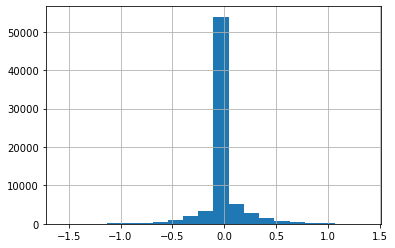

In [8]:
plt.figure()
df.angle.diff().hist(bins=20)
df.angle.head()
# Angles

0    0.008523
1    0.008523
2    0.077458
3    0.077458
4    0.124850
Name: throttle, dtype: float64

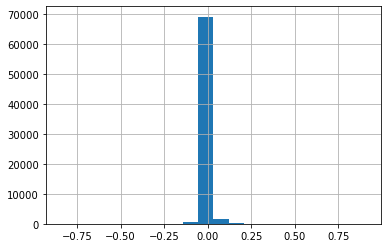

In [9]:
plt.figure()
df.throttle.diff().hist(bins=20)
df.throttle.head()
# Throttle

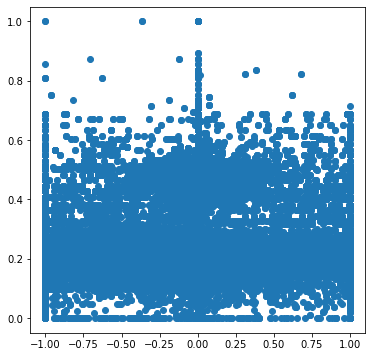

In [10]:
plt.figure(figsize=(6, 6))
plt.scatter(df['angle'], df['throttle'])
plt.show()

In [9]:
#dls = ImageDataLoaders.from_df(df, '', fn_col=1, label_col=[2,3], y_block= RegressionBlock(n_out=2), 
#                               bs=128, seed=42)

In [7]:
class RandFlip(RandTransform):
    def __init__(self, p=1.0, **kwargs):
        super().__init__(p, **kwargs)
    def encodes(self, o: Tensor): 
        return Tensor([-o[0], o[1]])   # this reverses the target steering value
    def encodes(self, o: PILImage):
        return ImageOps.mirror(o)     # this mirrors the input image

In [8]:
#valid_idx = (df.iloc[:,'validation_set'] if isinstance('validation_set', int) else df['validation_set']).values.astype('bool')

nav = DataBlock(
    blocks     = (ImageBlock(cls=PILImage) , RegressionBlock(n_out=2)),
    get_x      = ColReader('image', pref=''), 
    get_y      = ColReader(['angle','throttle']),
    splitter   = ColSplitter('validation_set'),
    item_tfms  = [RandFlip(.5)],
    batch_tfms = aug_transforms(do_flip=False, flip_vert=False, max_rotate=0, 
                              min_zoom=0, max_zoom=0, max_warp=0, p_affine=0,
                              max_lighting=0.8, p_lighting=0.8, xtra_tfms=Normalize()) 
)

dls = nav.dataloaders(df, bs=512)
test_dl = dls.test_dl(df_test, with_labels=True)


In [56]:
dls.c

2

In [57]:
dls.show

<bound method Datasets.show of (#57610) [(PILImage mode=RGB size=160x120, tensor([-0.0290,  0.0085])),(PILImage mode=RGB size=160x120, tensor([-0.0290,  0.0085])),(PILImage mode=RGB size=160x120, tensor([-0.0290,  0.0775])),(PILImage mode=RGB size=160x120, tensor([-0.0290,  0.0775])),(PILImage mode=RGB size=160x120, tensor([-0.0290,  0.1249])),(PILImage mode=RGB size=160x120, tensor([-0.0290,  0.1249])),(PILImage mode=RGB size=160x120, tensor([-0.0290,  0.2670])),(PILImage mode=RGB size=160x120, tensor([-0.0290,  0.2670])),(PILImage mode=RGB size=160x120, tensor([-0.0290,  0.3187])),(PILImage mode=RGB size=160x120, tensor([-0.0290,  0.3187]))...]>

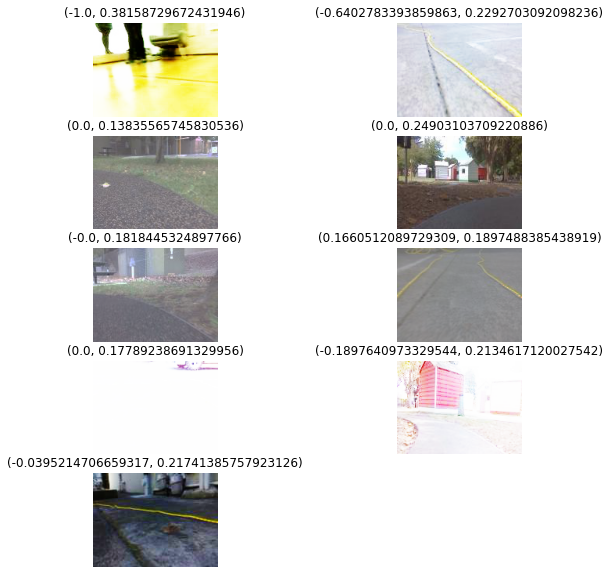

In [58]:
dls.show_batch(nrows=5,ncols=2,figsize=(10,10))
 

### A reinterpratiaton of the Donkey Cars Linear model from Tensorflow to PyTorch 
https://github.com/autorope/donkeycar/blob/dev/donkeycar/parts/keras.py

### Tensorflow
def default_n_linear(num_outputs, input_shape=(120, 160, 3), roi_crop=(0, 0)):

    drop = 0.1

    #we now expect that cropping done elsewhere. we will adjust our expeected image size here:
    input_shape = adjust_input_shape(input_shape, roi_crop)
    
    img_in = Input(shape=input_shape, name='img_in')
    x = img_in
    x = Convolution2D(24, (5,5), strides=(2,2), activation='relu', name="conv2d_1")(x)
    x = Dropout(drop)(x)
    x = Convolution2D(32, (5,5), strides=(2,2), activation='relu', name="conv2d_2")(x)
    x = Dropout(drop)(x)
    x = Convolution2D(64, (5,5), strides=(2,2), activation='relu', name="conv2d_3")(x)
    x = Dropout(drop)(x)
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_4")(x)
    x = Dropout(drop)(x)
    x = Convolution2D(64, (3,3), strides=(1,1), activation='relu', name="conv2d_5")(x)
    x = Dropout(drop)(x)
    
    x = Flatten(name='flattened')(x)
    x = Dense(100, activation='relu')(x)
    x = Dropout(drop)(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(drop)(x)

    outputs = []
    
    for i in range(num_outputs):
        outputs.append(Dense(1, activation='linear', name='n_outputs' + str(i))(x))
        
    model = Model(inputs=[img_in], outputs=outputs)
    
    return model

In [23]:
# Pytorch
class DonkeycarLinear(nn.Module):
    def __init__(self):
        super(DonkeycarLinear, self).__init__()
        self.dropout = 0.1
        # init the layers
        self.conv24 = nn.Conv2d(3, 24, kernel_size=(5,5), stride=(2,2))
        self.conv32 = nn.Conv2d(24, 32, kernel_size=(5,5), stride=(2,2))
        self.conv64_5 = nn.Conv2d(32, 64, kernel_size=(5,5), stride=(2,2))
        self.conv64_3 = nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1))
        self.fc1 = nn.Linear(64 * 8 * 13, 100)
        self.fc2 = nn.Linear(100, 50)
        self.drop = nn.Dropout(self.dropout)
        self.relu = nn.ReLU()
        self.output = nn.Linear(50, 2)
        self.flatten = nn.Flatten()
        
        
    def forward(self, x):
        x = self.relu(self.conv24(x))
        x = self.drop(x)
        x = self.relu(self.conv32(x))
        x = self.drop(x)
        x = self.relu(self.conv64_5(x))
        x = self.drop(x)        
        x = self.relu(self.conv64_3(x))
        x = self.drop(x)
        x = self.relu(self.conv64_3(x))
        x = self.drop(x)        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)

        
        return self.output(x)

In [24]:
model = DonkeycarLinear()

In [26]:
learn = Learner(dls, model, oss_func = MSELossFlat(), metrics=[rmse])
print(learn.summary())
print(learn.loss_func)


DonkeycarLinear (Input shape: ['256 x 3 x 120 x 160'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               256 x 24 x 58 x 78   1,824      True      
________________________________________________________________
Conv2d               256 x 32 x 27 x 37   19,232     True      
________________________________________________________________
Conv2d               256 x 64 x 12 x 17   51,264     True      
________________________________________________________________
Conv2d               256 x 64 x 8 x 13    36,928     True      
________________________________________________________________
Linear               256 x 100            665,700    True      
________________________________________________________________
Linear               256 x 50             5,050      True      
________________________________________________________________
Dropout              256 x 50             0          False     
___________________________________________

Minimum/10: 1.10e-03, steepest point: 1.91e-04


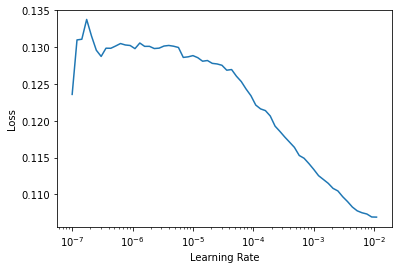

In [62]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [63]:
learn.fit_one_cycle(15, 1.91e-04)


epoch,train_loss,valid_loss,_rmse,time
0,0.095577,0.096977,0.311412,00:18
1,0.089225,0.091718,0.302850,00:17
2,0.083727,0.085240,0.291959,00:17
3,0.079868,0.079528,0.282006,00:17
4,0.073791,0.072205,0.268710,00:17
5,0.064884,0.065543,0.256014,00:17
6,0.059466,0.059607,0.244146,00:17
7,0.057120,0.055915,0.236463,00:18
8,0.054915,0.055493,0.235569,00:20
9,0.053566,0.053437,0.231165,00:19


In [64]:
learn.save('donkey_model_linear')

Path('models/donkey_model_linear.pth')

In [23]:
learn.load('donkey_model_linear')

In [65]:
def plot_loss_stats(learn):
    learn.recorder.plot_loss()
    learn.show_results(nrows=5, figsize=(10,10))

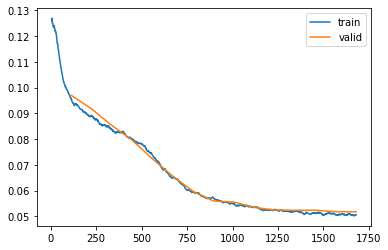

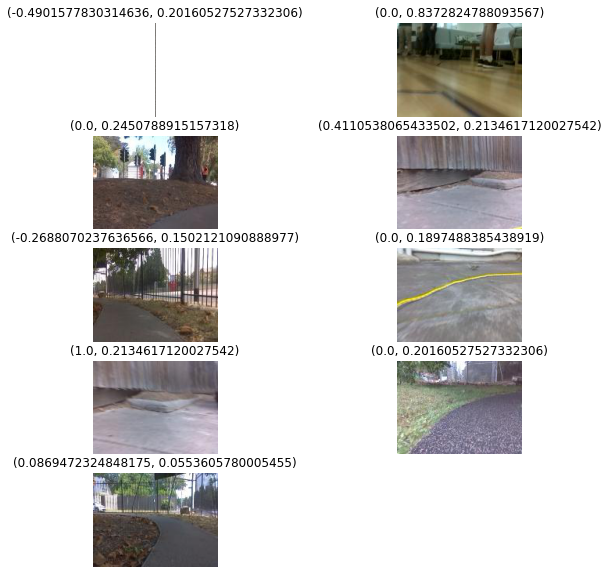

In [66]:
plot_loss_stats(learn)

In [17]:
def graph_preds():
    preds, tgt = learn.get_preds(dl=test_dl)
    print(rmse(preds,tgt))
    #Steering
    plt.title("Target vs Predicted Steering", fontsize=18, y=1.0)
    plt.xlabel("Target", fontsize=14, labelpad=15)
    plt.ylabel("Predicted", fontsize=14, labelpad=15)
    plt.plot(tgt.T[0], preds.T[0],'bo')
    plt.plot([-1,1],[-1,1],'r', linewidth = 4)
    plt.show()
    
    #Throttle
    plt.title("Target vs Predicted Throttle", fontsize=18, y=1.02)
    plt.xlabel("Target", fontsize=14, labelpad=15)
    plt.ylabel("Predicted", fontsize=14, labelpad=15)
    plt.plot(tgt.T[1], preds.T[1],'bo')
    plt.plot([0,1],[0,1],'r', linewidth = 4)
    plt.show()    

TensorImage(0.2270)


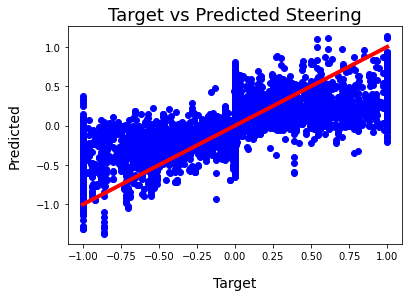

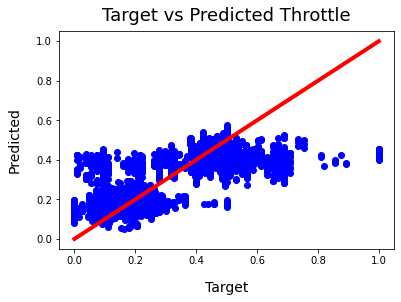

In [68]:
graph_preds()

In [38]:
### Testing Model https://github.com/cmasenas/fastai_navigation_training/blob/master/fastai_train.ipynb

In [72]:
model = nn.Sequential(
        ConvLayer(3, 16, stride=2),
        ConvLayer(16, 32, stride=2),
        ConvLayer(32, 64, stride=2),
        ConvLayer(64, 128, stride=2),
        ConvLayer(128, 256, stride=2),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        nn.Linear(256, dls.c))

In [73]:
learn = Learner(dls, model, oss_func = MSELossFlat(), metrics=[rmse], )
print(learn.summary())
print(learn.loss_func)

Sequential (Input shape: ['512 x 3 x 120 x 160'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               512 x 16 x 60 x 80   432        True      
________________________________________________________________
BatchNorm2d          512 x 16 x 60 x 80   32         True      
________________________________________________________________
ReLU                 512 x 16 x 60 x 80   0          False     
________________________________________________________________
Conv2d               512 x 32 x 30 x 40   4,608      True      
________________________________________________________________
BatchNorm2d          512 x 32 x 30 x 40   64         True      
________________________________________________________________
ReLU                 512 x 32 x 30 x 40   0          False     
________________________________________________________________
Conv2d               512 x 64 x 15 x 20   18,432     True      
________________________________________________

Minimum/10: 4.79e-03, steepest point: 5.75e-04


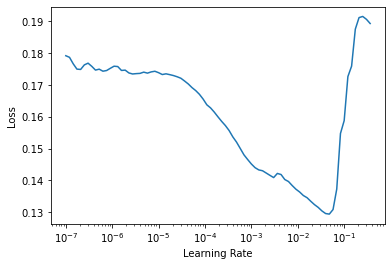

In [74]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [75]:
learn.fit_one_cycle(15, 4.79e-03)

epoch,train_loss,valid_loss,_rmse,time
0,0.086665,0.085423,0.292273,00:17
1,0.074248,0.079486,0.281933,00:17
2,0.067786,0.066855,0.258563,00:17
3,0.059489,0.068210,0.261171,00:17
4,0.054306,0.057337,0.239452,00:16
5,0.050833,0.055231,0.235013,00:16
6,0.048887,0.055051,0.234629,00:16
7,0.045791,0.050079,0.223784,00:16
8,0.044388,0.051381,0.226673,00:16
9,0.041487,0.049661,0.222848,00:16


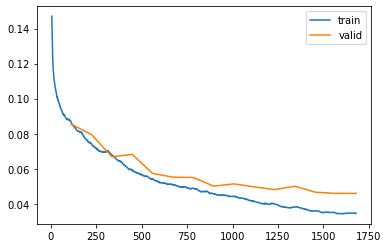

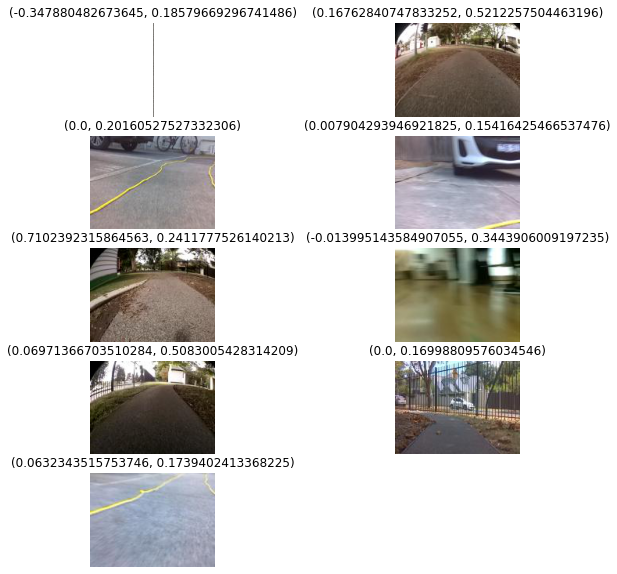

In [76]:
plot_loss_stats(learn)

TensorImage(0.1895)


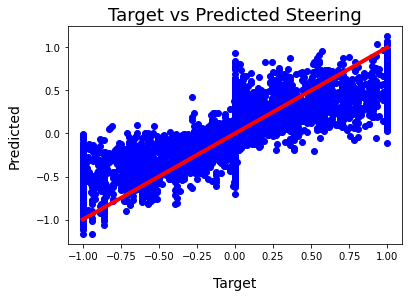

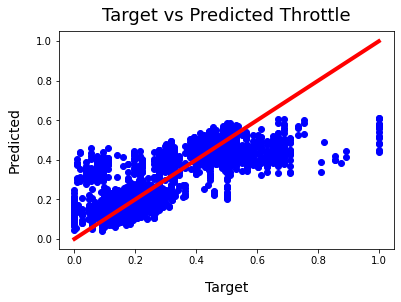

In [78]:
graph_preds()

### My Experimental Version

In [79]:
model = nn.Sequential(
        ConvLayer(3, 24, stride=2, ks=5),
        ConvLayer(24, 32, stride=2, ks=5),
        ConvLayer(32, 64, stride=2, ks=5),
        ConvLayer(64, 64, stride=2, ks=5),
        ConvLayer(64, 64, stride=2, ks=3),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        LinBnDrop(64, 512),
        LinBnDrop(512, dls.c))

In [80]:
learn = Learner(dls, model, oss_func = MSELossFlat(), metrics=[rmse])
print(learn.summary())
print(learn.loss_func)

Sequential (Input shape: ['512 x 3 x 120 x 160'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               512 x 24 x 60 x 80   1,800      True      
________________________________________________________________
BatchNorm2d          512 x 24 x 60 x 80   48         True      
________________________________________________________________
ReLU                 512 x 24 x 60 x 80   0          False     
________________________________________________________________
Conv2d               512 x 32 x 30 x 40   19,200     True      
________________________________________________________________
BatchNorm2d          512 x 32 x 30 x 40   64         True      
________________________________________________________________
ReLU                 512 x 32 x 30 x 40   0          False     
________________________________________________________________
Conv2d               512 x 64 x 15 x 20   51,200     True      
________________________________________________

Minimum/10: 9.12e-04, steepest point: 1.74e-05


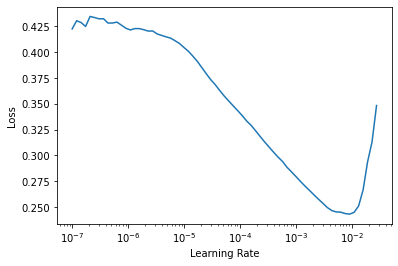

In [81]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [82]:
learn.fit_one_cycle(10, 9.12e-04)

epoch,train_loss,valid_loss,_rmse,time
0,0.117671,0.098680,0.314134,00:21
1,0.091047,0.081016,0.284634,00:21
2,0.079439,0.072804,0.269821,00:21
3,0.072775,0.074829,0.273549,00:21
4,0.066190,0.067124,0.259082,00:21
5,0.059953,0.058655,0.242189,00:22
6,0.054394,0.056693,0.238103,00:21
7,0.051391,0.053255,0.230770,00:21
8,0.049049,0.052248,0.228578,00:21
9,0.047493,0.052059,0.228165,00:21


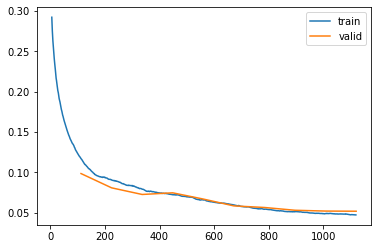

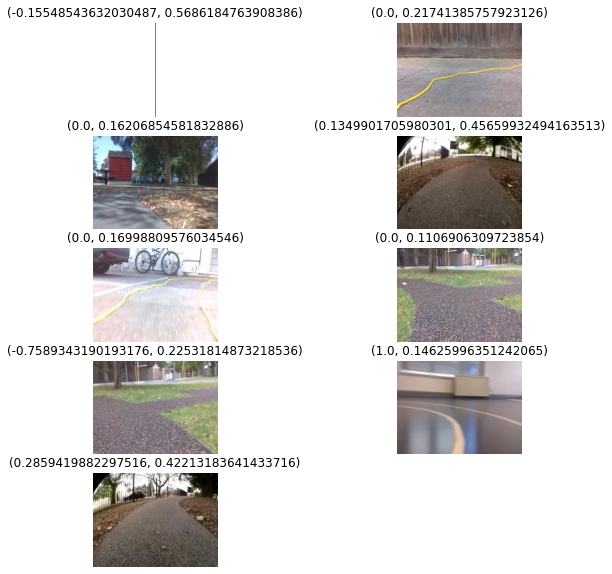

In [83]:
plot_loss_stats(learn)

TensorImage(0.2212)


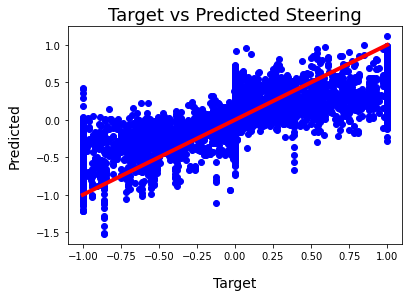

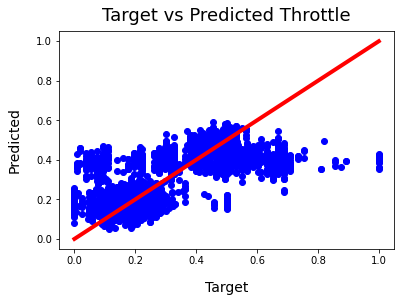

In [85]:
graph_preds()

### Model with one less Linear layer

In [86]:
model = nn.Sequential(
        ConvLayer(3, 24, stride=2, ks=5),
        ConvLayer(24, 32, stride=2, ks=5),
        ConvLayer(32, 64, stride=2, ks=5),
        ConvLayer(64, 64, stride=2, ks=5),
        ConvLayer(64, 64, stride=2, ks=3),
        nn.AdaptiveAvgPool2d(1),
        Flatten(),
        LinBnDrop(64, dls.c))

In [87]:
learn = Learner(dls, model, oss_func = MSELossFlat(), metrics=[rmse])
print(learn.summary())
print(learn.loss_func)

Sequential (Input shape: ['512 x 3 x 120 x 160'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               512 x 24 x 60 x 80   1,800      True      
________________________________________________________________
BatchNorm2d          512 x 24 x 60 x 80   48         True      
________________________________________________________________
ReLU                 512 x 24 x 60 x 80   0          False     
________________________________________________________________
Conv2d               512 x 32 x 30 x 40   19,200     True      
________________________________________________________________
BatchNorm2d          512 x 32 x 30 x 40   64         True      
________________________________________________________________
ReLU                 512 x 32 x 30 x 40   0          False     
________________________________________________________________
Conv2d               512 x 64 x 15 x 20   51,200     True      
________________________________________________

Minimum/10: 1.00e-02, steepest point: 4.79e-04


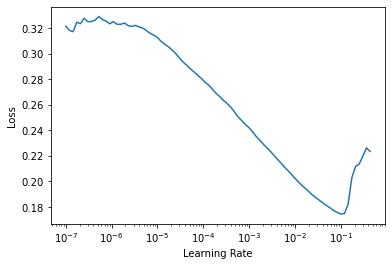

In [88]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [89]:
learn.fit_one_cycle(15, 1.10e-02)

epoch,train_loss,valid_loss,_rmse,time
0,0.098367,0.089567,0.299277,00:20
1,0.077830,0.072038,0.268398,00:20
2,0.069940,0.100505,0.317025,00:20
3,0.062389,0.058155,0.241153,00:20
4,0.056170,0.054923,0.234356,00:19
5,0.051947,0.052118,0.228295,00:19
6,0.048516,0.049360,0.222170,00:20
7,0.046710,0.053646,0.231615,00:20
8,0.044159,0.047696,0.218395,00:20
9,0.041368,0.046017,0.214515,00:19


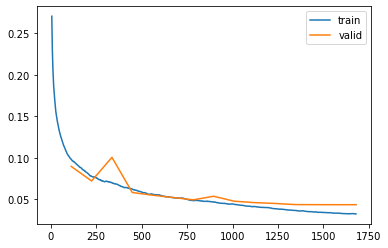

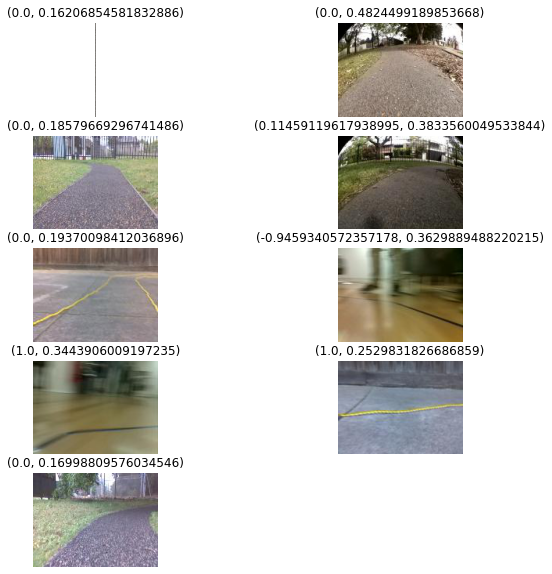

In [90]:
plot_loss_stats(learn)

TensorImage(0.1829)


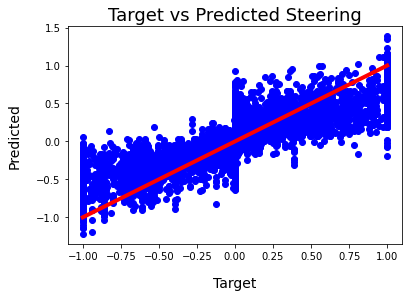

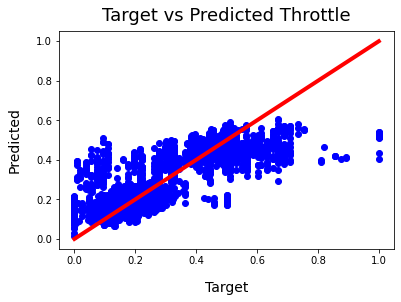

In [91]:
graph_preds()

# xresnet18

In [9]:
dls = nav.dataloaders(df, bs=256)
test_dl = dls.test_dl(df_test, with_labels=True)
gc.collect() 
torch.cuda.empty_cache()

In [10]:
learn = cnn_learner(dls, xresnet18, metrics=[rmse])
print(learn.summary())
print(learn.loss_func)

Sequential (Input shape: ['256 x 3 x 120 x 160'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               256 x 32 x 60 x 80   864        False     
________________________________________________________________
BatchNorm2d          256 x 32 x 60 x 80   64         True      
________________________________________________________________
ReLU                 256 x 32 x 60 x 80   0          False     
________________________________________________________________
Conv2d               256 x 32 x 60 x 80   9,216      False     
________________________________________________________________
BatchNorm2d          256 x 32 x 60 x 80   64         True      
________________________________________________________________
ReLU                 256 x 32 x 60 x 80   0          False     
________________________________________________________________
Conv2d               256 x 64 x 60 x 80   18,432     False     
________________________________________________

Minimum/10: 6.92e-03, steepest point: 2.75e-02


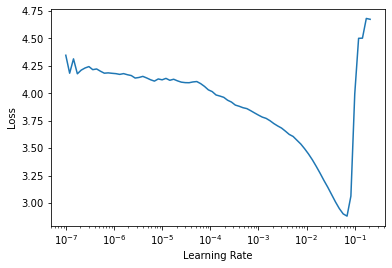

In [14]:
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [15]:
learn.fit_one_cycle(5, 6.92e-03)

epoch,train_loss,valid_loss,_rmse,time
0,0.262564,0.077095,0.277660,01:14
1,0.092056,0.079307,0.281615,01:16
2,0.075432,0.060621,0.246214,01:16
3,0.061758,0.054245,0.232905,01:16
4,0.055733,0.051477,0.226885,01:16


In [16]:
learn.save('xresnet18')

Path('models/xresnet18.pth')

In [11]:
learn.load('xresnet18')

Minimum/10: 3.02e-06, steepest point: 7.59e-07


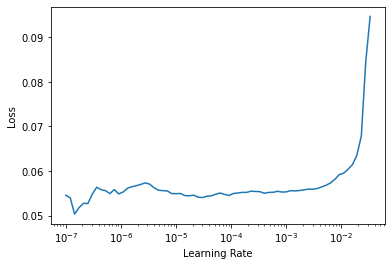

In [12]:
learn.unfreeze()
lr_min,lr_steep = learn.lr_find()
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")

In [13]:
learn.fine_tune(5, 3.02e-06)

epoch,train_loss,valid_loss,_rmse,time
0,0.056084,0.051379,0.226670,01:18


epoch,train_loss,valid_loss,_rmse,time
0,0.055408,0.051412,0.226741,01:39
1,0.055194,0.051543,0.227032,01:39
2,0.055082,0.051538,0.227020,01:40
3,0.055510,0.051201,0.226276,01:41
4,0.055819,0.051235,0.226351,01:41


In [14]:
learn.save('xresnet18_fine')

Path('models/xresnet18_fine.pth')

In [8]:
learn.load('xresnet18_fine')

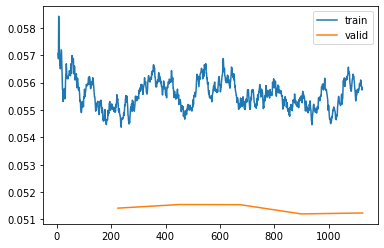

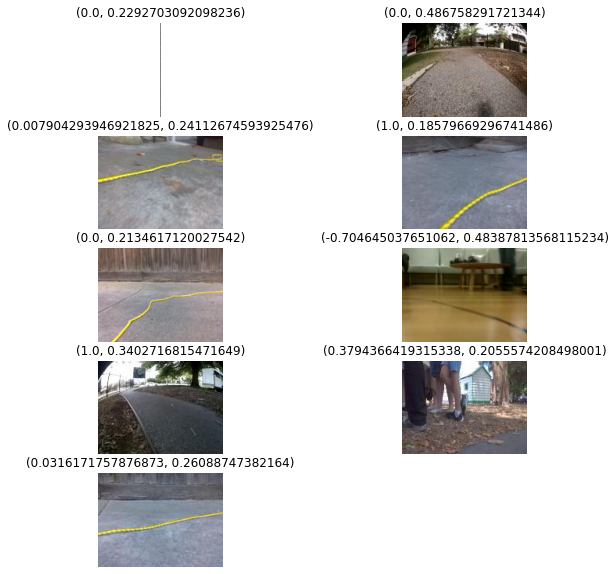

In [15]:
#plot_loss_stats(learn)
learn.recorder.plot_loss()
learn.show_results(nrows=5, figsize=(10,10))

TensorImage(0.2307)


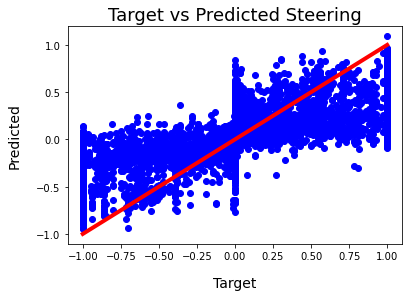

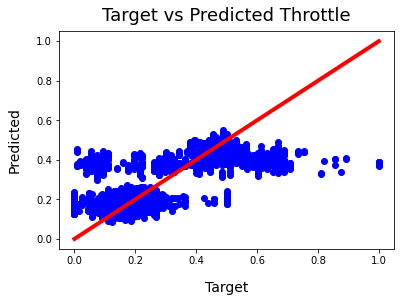

In [18]:
graph_preds()